In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import datetime as dt

### Get data from sentiment analysis

In [158]:
sentiment_df = pd.read_csv('./data/sentiment_df.csv')
sentiment_df.head()

,quoteID,quotation,speaker,date,numOccurrences,neg,neu,pos,compound,date_clean
0,2015-01-01-041284,With major new premium services from Apple and...,Geoff Taylor,2015-01-01 00:01:00,3,0.0,0.854,0.146,0.5859,2015-01-01
1,2015-01-01-032875,They realize that they just can't assume that ...,Angus King,2015-01-01 00:14:24,1,0.0,0.892,0.108,0.6369,2015-01-01
2,2015-01-01-036563,We feel that there are a substantial number of...,William Anderson,2015-01-01 01:30:18,1,0.0,0.795,0.205,0.2732,2015-01-01
3,2015-01-01-041777,You can play a murderer's row but in conferenc...,Jim Crews,2015-01-01 02:47:17,1,0.0,0.769,0.231,0.5859,2015-01-01
4,2015-01-01-039665,"We've also, surprisingly, had a lot of Apple r...",Daniel Williams,2015-01-01 04:10:31,1,0.0,0.804,0.196,0.2960,2015-01-01


In [159]:
# Try aggregate on weekly values, i.e. 7 days
# Based on how much they contribute increase size of scatter plot circle
agg_month_sentiment = []
agg_month_dates = []

for index, (idx, row) in enumerate(sentiment_df.iterrows()):
    date = row['date_clean']
    if index == 0:
        current_month = date[:7]
        current_size = 0

    tmp_month = current_month
    current_month = date[:7] # the seven first digits of the date
    if tmp_month != current_month:
        agg_month_sentiment.append(current_size)
        current_size = 0
        agg_month_dates.append(current_month)
    
    # updates weighted aggregated value of positive and negative
    current_size += row['compound'] #*row['numOccurrences']

In [160]:
result_values = []
result_mon = []
for mon, agg in zip(agg_month_dates, agg_month_sentiment):
    result_values.append(agg)
    result_mon.append(mon)

### Get data from stock analysis

In [161]:
stock_data=pd.read_csv('./data/AAPL_2015_to_2020_yahoo_finance.csv')
apple_event_and_stock_data=pd.read_csv('./data/events_dates_with_stock_data.csv')
apple_earnings_and_stock_data=pd.read_csv('./data/earnings_dates_with_stock_data.csv')

### Group by week

In [162]:
stock_data_weekly_average=stock_data.copy()

#Create a new dataframe containing the weekly average of the stock price. The method is obtained from
stock_data_weekly_average.Date = pd.to_datetime(stock_data_weekly_average.Date) - pd.to_timedelta(7, unit='d')
stock_data_weekly_average = stock_data_weekly_average.groupby([pd.Grouper(key='Date', freq='W-MON')]).mean().reset_index().sort_values('Date')

### Calculate monthly change

In [163]:
stock_data["Date"]=stock_data['Date'].apply(lambda x: dt.datetime.strptime(x[:10], '%Y-%m-%d'))

In [164]:
monthly_stock_diff_df=pd.DataFrame(stock_data.groupby(pd.Grouper(key='Date', freq="M")).first()["Open"]-stock_data.groupby(pd.Grouper(key='Date', freq="M")).last()["Close"], columns=["price_difference"])

In [165]:
monthly_stock_diff_df.head()

,price_difference
Date,
2015-01-31,-1.442501
2015-02-28,-2.602501
2015-03-31,1.205000
2015-04-30,-0.082500
2015-05-31,-1.045000


`monthly_stock_diff` displays the monthly price change off the Apple-stock.

## See if there is any correlation between stock and sentiment

Create a monthly aggregated sentiment dataframe

In [166]:
sentiment_monthly_df=pd.DataFrame(zip(result_mon, result_values), columns =['Date', 'Values'])
sentiment_monthly_df['Date'] = sentiment_monthly_df['Date'].apply(lambda x: dt.datetime.strptime(x[:10], '%Y-%m'))

In [167]:
sentiment_monthly_df.head()

,Date,Values
0,2015-02-01,375.3895
1,2015-03-01,336.9674
2,2015-04-01,541.0418
3,2015-05-01,463.2872
4,2015-06-01,281.1544


As the `sentiment_monthly_df` use the first date of the next month used to calculate sentiment, while `monthly_stock_diff` use the last day of the month used to calculate stock difference, we change the date of `sentiment_monthly_df` by one day before merging them.

In [168]:
from pandas.tseries.offsets import DateOffset

sentiment_monthly_df['Date']=sentiment_monthly_df['Date']-DateOffset(days=1)

In [169]:
sentiment_monthly_df.head()

,Date,Values
0,2015-01-31,375.3895
1,2015-02-28,336.9674
2,2015-03-31,541.0418
3,2015-04-30,463.2872
4,2015-05-31,281.1544


Plot the development of the stock price and the development of the sentiment to see if there is any obvious relationships.

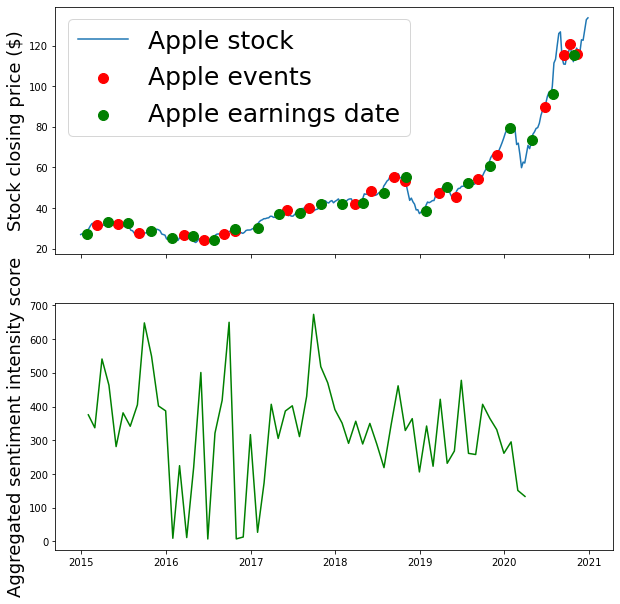

In [170]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,10))
ax1.plot(stock_data_weekly_average.Date,stock_data_weekly_average.Close, label='Apple stock')
ax1.set_ylabel('Stock closing price ($)', size=18)
ax1.scatter(apple_event_and_stock_data.Date, apple_event_and_stock_data.Close, c="r", s=100, zorder=3, label='Apple events')
ax1.scatter(apple_earnings_and_stock_data.Date, apple_earnings_and_stock_data.Close, c="g", s=100, zorder=3, label='Apple earnings date')
ax1.legend(prop={'size': 25})

ax2.plot(sentiment_monthly_df.Date, sentiment_monthly_df.Values, color='green')
ax2.set_ylabel('Aggregated sentiment intensity score', fontsize=18)
plt.show();

By just looking at the plots, it is not easy to tell if the sentiment and the stock price is related in any way. We therefore tries to merge the two dataframes by the Date-column to further explore the relationships between the the sentiment and price.

In [171]:
stock_price_sentiment = pd.merge(monthly_stock_diff_df, sentiment_monthly_df, how='inner', on = 'Date')

In [172]:
stock_price_sentiment.head()

,Date,price_difference,Values
0,2015-01-31,-1.442501,375.3895
1,2015-02-28,-2.602501,336.9674
2,2015-03-31,1.205000,541.0418
3,2015-04-30,-0.082500,463.2872
4,2015-05-31,-1.045000,281.1544


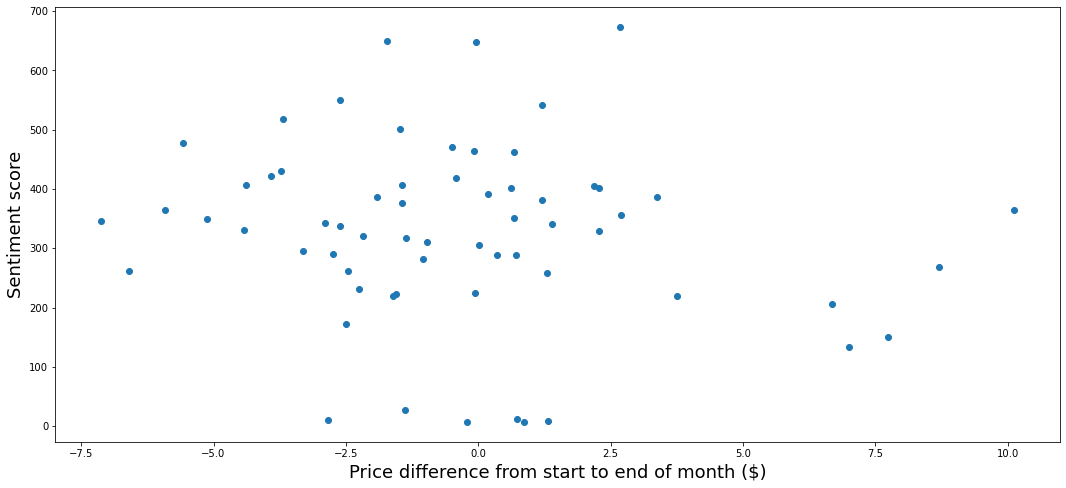

In [173]:
fig,ax = plt.subplots(figsize=(18,8))
ax.scatter(stock_price_sentiment.price_difference, stock_price_sentiment.Values, label='Apple stock')
ax.set_xlabel('Price difference from start to end of month ($)', size=18)
ax.set_ylabel('Sentiment score', size=18)
plt.show()

## Stock API


In [174]:
#import requests

# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
#url = 'https://www.alphavantage.co/query?function=TIME_SERIES_WEEKLY_ADJUSTED&symbol=AAPL&apikey=API'
#r = requests.get(url)
#data = r.json()

#print(data)